# Kontur-test

### Задача: Классификация новостных заголовков на реальные и ложные.

Импортируем необходимые библиотеки.

In [243]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import gensim
import string
from collections import defaultdict


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,GRU,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

russian_stopwords = stopwords.words("russian")
pd.options.display.max_colwidth = 1

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\George/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Посмотрим на данные.  

In [244]:
train = pd.read_csv('train.tsv',sep = '\t') # уже размеченные данные
test = pd.read_csv('test.tsv',sep = '\t')   # данные, которые нужно будет разметить
train.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы,1
1,Агент Кокорина назвал езду по встречке житейской историей,0
2,Госдума рассмотрит возможность введения секретных статей Уголовного кодекса,1
3,ФАС заблокировала поставку скоростных трамваев для Москвы,0
4,Против Навального завели дело о недоносительстве на Волкова,1


1 - фейковая новость  
0 - реальная новость

Посмотрим на накоторые настоящие новостные заголовки

In [245]:
train[train.is_fake == 0].head(10)

,title,is_fake
1,Агент Кокорина назвал езду по встречке житейской историей,0
3,ФАС заблокировала поставку скоростных трамваев для Москвы,0
7,Россияне обхитрили рост цен,0
8,Звезда «Ворониных» раскрыл подробности о своем состоянии,0
9,Microsoft объявила дату выхода очков дополненной реальности Hololens,0
13,Топилин провозгласил окончание зарплатного кризиса в России,0
14,Режиссера Алексея Германа наградили орденом,0
18,Энтони Андерсон стал молодым папашей,0
20,Ubisoft анонсировала новую часть игры Ghost Recon,0
21,На Байконуре сломали малайзийский спутник,0


Теперь на фейковые.

In [246]:
train[train.is_fake == 1].head(10)

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы,1
2,Госдума рассмотрит возможность введения секретных статей Уголовного кодекса,1
4,Против Навального завели дело о недоносительстве на Волкова,1
5,Российским студентам запретят учиться за рубежом,1
6,Путин пишет книгу об истории Украины,1
10,Марат Хуснуллин призвал прописать в законе понятие многонационального дома,1
11,Для проведения профилактических работ с 15 по 19 сентября в России отключат интернет,1
12,В России введут обязательный техосмотр садового инвентаря,1
15,"Олаф Шольц: «Дед рассказывал, какие вкусные на Украине куры, молоко и яйца»",1
16,"Беглов: «Петербург был основан до нашей эры, он на полторы тысячи лет старше Москвы»",1


In [247]:
train.shape

(5758, 2)

In [248]:
test.shape

(1000, 2)

Посмотрим на количество примеров класса 0 и 1 в данных

In [249]:
train.is_fake.value_counts()

1    2879
0    2879
Name: is_fake, dtype: int64

Для дальнейшего анализа объеденим train и test

In [250]:
df = pd.concat([train,test])

## Предобработка  
### Предобработка будет содержать следующие пункты:  
1) Приведение текста к нижнему регистру  
2) Удаление пунктуации  
3) Удаление стоп-слов  

In [251]:
def preprocessing(data):
    """data должен иметь тип  pandas.core.frame.DataFrame"""
    
    # удаление пунктуации
    df['title']=df['title'].apply(lambda x : remove_punct(x))
    
    # удаление стоп-слов,цифр, привидение к нижнему регистру
    corpus=[]
    for train in tqdm(data['title']):
        words=[word.lower() for word in word_tokenize(train) if((word.isalpha()==1) & (word not in russian_stopwords) & (len(word)>3))]
        corpus.append(words)
    
    # попытка заменить незнакомые слова
    
    pass

Посмотрим какие стоп-слова встречаются в данных.

In [252]:
def create_corpus():
    """Функция, которая создает массив всех слов в датафрейме"""
    corpus=[]
    for x in df['title'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [253]:
corpus = create_corpus()
dic = defaultdict(int)

for word in corpus:
    if word in russian_stopwords:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:30] 

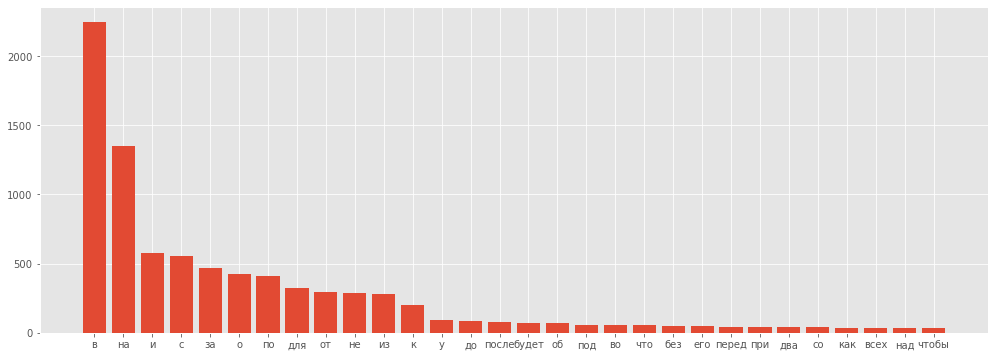

In [254]:
x,y=zip(*top)

fig, ax = plt.subplots()

ax.bar(x, y)

fig.set_figwidth(17)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure

plt.show()

Посмотрим какие знаки пунктуации содержатся в данных

In [255]:
plt.figure(figsize=(10,5))
corpus=create_corpus()

dic=defaultdict(int)
special = string.punctuation + "»" + '«'+ "°"
for i in range(len(corpus)):
    for punkt in special:
        if punkt in corpus[i]:
            dic[punkt]+=1
            print(corpus[i])
        


«Ворониных»
«Ворониных»
Шольц:
«Дед
рассказывал,
куры,
яйца»
Беглов:
«Петербург
эры,
Москвы»
«ЭпиВакКорона»
«ЭпиВакКорона»
двойников,
QR-кодах
«Континууме»
«Континууме»
рок-н-ролла
&
онлайн-свадьбах
Рашкин:
премьер-министра
из-за
Евро-2008
Greenpeace*
Из-за
«Моя
конституция»
золото,
из-за
«Барселона»
«Барселона»
70-летняя
«Спутником
V»
полицейского,
«мобильного
рабства»
COVID-19
«Минск.
«Минск.
домой»
Дауни-младший
«Великого
Гэтсби»
«Норникеля»
«Норникеля»
граждан,
«Пятёрочка»
«Пятёрочка»
100-летний
«Работа
России»
«Газпром»
«Газпром»
«национальным
достоянием»
«слишком
белую»
90-процентную
девушек,
из-за
краш-тесте
разбился,
Иванов:
свой-чужой
из-за
хот-доги
генетики:
«Только
говорить,
чем-то
мышам»
признался,
QR-код
помощью”:
«Комсомольская
правда»
Навального,
«Газпром»
«Газпром»
Комсомольске-на-Амуре
«Как
сталь»
«Единая
Россия»
из-за
«Розовый
кролик»
«Талибан»*
«Талибан»*
«Талибан»*
«Юнармии»
«Юнармии»
рассказал,
«Ридус»
«Ридус»
Азиатско-Тихоокеанском
«Б1
Maximum»
«ГлавКлуб»
«ГлавКлу

COVID-19
51-ю
мира-2017
«Победа»
«Победа»
7,5%
7,5%
Из-за
1,5
из-за
«Терек»
«Терек»
«Тополь-М»
«Тополь-М»
«Тополь-М»
школьницы,
«Спартака»
«Спартака»
«Дети
Online»
бета-тестирования
«Башнефти»
«Башнефти»
пенсионерке,
Байден:
«В
50%
США»
Яровая:
цензура,
Певица-шансонье
«Свинки
Пеппы»
COVID-19
0,1
государства,
«сделано
стране»
25-томной
«Тинькофф»
«Тинькофф»
Сталина!”
«АйМаниБанка»
«АйМаниБанка»
заметили,
объяснили,
«Электро-Л»
«Электро-Л»
«Электро-Л»
SSJ-100
фастфуды,
России,
злоумышленника,
Office:
«Капитан
«Defender»
«Defender»
назад»
«Роль
товарищества»
Пентагон:
Дэвиса:
встречу,
«Космос»
«Космос»
выставка-продажа
«Деликатесы
Камчатки»
«Поросёнок
возвращается»
С++
из-за
колл-центра
«Матросской
тишины»
«Чёрная
сотня»
динозавра-невидимки
спортсменов,
Германии:
«Оркестр
компания»
«Евровидения»
«Евровидения»
Владивосток-Пекин
«Талибан»*
«Талибан»*
«Талибан»*
«скопинского
маньяка»
«дочки»
«дочки»
«Роснефти»
«Роснефти»
Россиян,
из-за
границы,
Tik-Tok
«Талибан»*
«Талибан»*
«Талибан»*
«Канд

Бельгии,
“опасными”,
«Евровидения»
«Евровидения»
«Альтернативы
Германии»
ХДС/ХСС
«спячке»
«спячке»
4,5
тревогу:
«Северного
потока-2»
потока-2»
70%
объяснил,
«Дочка»
«Дочка»
«Ярославль
пыточный»
из-за
школ,
Мастер-банк
секс-шопов
«Волка
Уолл-стрит»
Уолл-стрит»
из-за
«Зоя»
«Зоя»
улицы,
«Металлург»
«Металлург»
Навальным,
Явлинский,
«Панорама
недели»
объектов,
«Яблоко»
«Яблоко»
членов,
«Единую
Россию»
торрент-трекеры
народ,
Гоголь-центр
из-за
«У
ГУЛАГ,
долларов»:
долларов»:
«Формулы-1»
«Формулы-1»
«Формулы-1»
выяснили,
C-17
«Не
прошлого»:
прошлого»:
«Глобальное
потепление»
Формулы-1
Гран-при
жатву:
94-летний
Brazzers,
«Внешэкономбанк»
«Внешэкономбанк»
«Мечела»
«Мечела»
1/4
ЧМ-2012
«Час
Земли»
«прокатило»
«прокатило»
им.
из-за
«Мы
бомжи!»:
бомжи!»:
бомжи!»:
«Дом-2»
«Дом-2»
«Дом-2»
Су-27
пенсионеров,
Собянина,
мастер-класс
«Панорама
недели»
роуд-муви
«Тает
лед»
«вцепившегося
Трампа»
Пенсионеров,
дожития,
фермеры,
сельхозтехнику,
«Гоголь-центра»
«Гоголь-центра»
«Гоголь-центра»
«А»,
«А»,
«А»,


«Искандер»
«Искандер»
военнослужащих”:
объяснили,
финская,
день”:
«Галичина»
«Галичина»
«Зелёный
мыс»,
мыс»,
«Дюшес»
«Дюшес»
«Буратино»
«Буратино»
ухажеров,
корабли-доки
NASA:
из-за
китов,
Из-за
«Яндекс.Картах»
«Яндекс.Картах»
«Яндекс.Картах»
«Каше
топора»
прихожан,
Вице-чемпион
«боевой
картинкой»
Из-за
«Северного
потока-2»
потока-2»
«Северного
потока-3»
потока-3»
школьник,
Новости:
«белорусских»
«белорусских»
«сирийских»
«сирийских»
военных,
Евро-2020
«Этого
повториться»:
повториться»:
из-за
России,
«Роснефти»
«Роснефти»
«Игры
престолов»
Женщину,
сил,
«Роскосмоса»
«Роскосмоса»
«Теплоход
апарт-отеля»:
апарт-отеля»:
апарт-отеля»:
145-метровой
«Дяди
Стёпы»
из-за
мебель,
«Александр
Македонский-Рюрик:
Македонский-Рюрик:
российского»
Сити-менеджером
том,
Иуда,
мошенников,
молекулу-фрактал
«Протоколы
мудрецов»
«Гоголь-центра»
«Гоголь-центра»
«Гоголь-центра»
Чиновник,
коррупцию,
мужчина,
ВЦИОМ:
70%
«Ходит
дворе»:
дворе»:
граждан,
185-сантиметровые
из-за
«Трансаэро»
«Трансаэро»
ЧМ-1986
тех,
«М

<Figure size 720x360 with 0 Axes>

<BarContainer object of 21 artists>

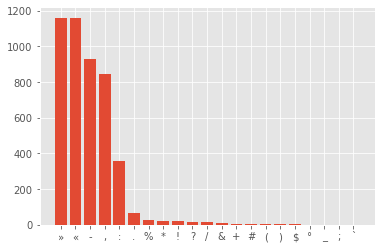

In [256]:
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)
x,y=zip(*top)
plt.bar(x,y)

In [257]:
type(corpus)

list

In [284]:
def remove_punct(line):
    spatial = string.punctuation + "»" + '«'+ "°"
    for p in spatial:
        if p in line:
            if (p == '-' or p=='°') and len(line)>1:
                line = line.replace(p, ' ')
            else:
                line = line.replace(p, '')
    return line

In [259]:
df['title']=df['title'].apply(lambda x : remove_punct(x))

In [260]:
df['title']=df['title'].apply(lambda x: x.lower())

In [261]:
df.head(10)

,title,is_fake
0,москвичу владимиру клутину пришёл счёт за вмешательство в американские выборы,1
1,агент кокорина назвал езду по встречке житейской историей,0
2,госдума рассмотрит возможность введения секретных статей уголовного кодекса,1
3,фас заблокировала поставку скоростных трамваев для москвы,0
4,против навального завели дело о недоносительстве на волкова,1
5,российским студентам запретят учиться за рубежом,1
6,путин пишет книгу об истории украины,1
7,россияне обхитрили рост цен,0
8,звезда ворониных раскрыл подробности о своем состоянии,0
9,microsoft объявила дату выхода очков дополненной реальности hololens,0


In [289]:
def create_corpus(df):
    corpus=[]
    for train in tqdm(df['title']):
        words=[word.lower() for word in word_tokenize(train) if((word.isalpha()==1) & (word not in russian_stopwords) & (len(word)>3))]
        corpus.append(words)
    return corpus

In [294]:
corpus=create_corpus(df)

100%|██████████| 6758/6758 [00:01<00:00, 5657.70it/s]


In [293]:
mx = 0
for i in range(len(corpus)):
    if len(corpus[i])>mx:
        mx = len(corpus[i])
mx

19

In [296]:
dic = defaultdict(int)

for i in corpus:
    dic[str(len(i))] += 1
        

<BarContainer object of 19 artists>

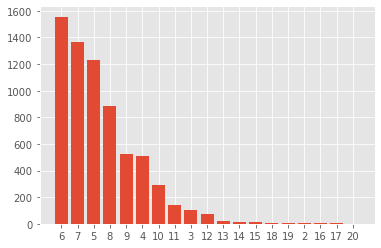

In [297]:

x,y=zip(*top)
plt.bar(x,y)

In [305]:
dic['12']

73

In [265]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

In [266]:
emb = NewsEmbedding()

In [267]:
known = 0
unknown = 0
unknown_became_known = 0
corpus_known = []
corpus_unknown = []
for i in range(len(corpus)):
    for j in range(len(corpus[i])):
        if corpus[i][j] in emb:
            known +=1
            corpus_known.append(corpus[i][j])
        else:
            unknown +=1
            if corpus[i][j][0:-1:1] in emb:
                unknown_became_known += 1
                corpus_known.append(corpus[i][j][0:-1:1])
            elif corpus[i][j][0:-2:1] in emb:
                unknown_became_known += 1
                corpus_known.append(corpus[i][j][0:-2:1])
            else:
                corpus_unknown.append(corpus[i][j])
print("Количество знакомых слов: ",known)
print("Количество незнакомых слов: ",unknown)
print("Количество слов, которые стали знакомыми после удаления 1-2 последних букв: ", unknown_became_known)
print("Итоговое кол-во незнакомых слов: ", unknown - unknown_became_known )

Количество знакомых слов:  43867
Количество незнакомых слов:  1707
Количество слов, которые стали знакомыми после удаления 1-2 последних букв:  422
Итоговое кол-во незнакомых слов:  1285


In [268]:
#теперь попробуем поставить слова в начальную форму используя наташку

In [269]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)
names_extractor = NamesExtractor(morph_vocab)

In [270]:
df.index = np.arange(len(df))

In [271]:
df

,title,is_fake
0,москвичу владимиру клутину пришёл счёт за вмешательство в американские выборы,1
1,агент кокорина назвал езду по встречке житейской историей,0
2,госдума рассмотрит возможность введения секретных статей уголовного кодекса,1
3,фас заблокировала поставку скоростных трамваев для москвы,0
4,против навального завели дело о недоносительстве на волкова,1
...,...,...
6753,прокуратура заподозрила явлинского в авторитарном стиле управления партией,0
6754,в день победы стратегические ракетоносцы ту 160 дадут боевой залп над красной площадью,0
6755,ск возбудил дело против авиакомпании победа за финансирование навального,0
6756,криптомонетный двор туркменистана выпустил юбилейные биткоины,0


In [272]:
for i in range(len(corpus_unknown)):
    corpus_unknown[i] = Doc(corpus_unknown[i])

In [273]:
corpus_lemms = []

In [274]:
for i in range(len(corpus_unknown)):
    corpus_unknown[i].segment(segmenter)
    corpus_unknown[i].tag_morph(morph_tagger)
    corpus_unknown[i].tokens[0].lemmatize(morph_vocab)
    corpus_lemms.append(corpus_unknown[i].tokens[0].lemma)

In [275]:
cnt = 0
uncnt = 0

In [276]:
for i in range(len(corpus_lemms)):
    if corpus_lemms[i] in emb:
        cnt +=1
        corpus_known.append(corpus_lemms[i])
    elif corpus_lemms[i][0:-1:1] in emb:
        cnt +=1
        corpus_known.append(corpus_lemms[i][0:-1:1])
    elif corpus_lemms[i][0:-2:1] in emb:
        cnt +=1
        corpus_known.append(corpus_lemms[i][0:-2:1])
    else:
        uncnt += 1

print(cnt)
# 349 слов изучено

349


In [277]:
len(corpus_known)

44638

In [278]:
len(set(corpus_known))

18806

In [279]:
'бузова' in emb

True

In [105]:
MAX_LEN=20
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [106]:
tweet_pad

array([[ 6801,  1816,  6802, ...,     0,     0,     0],
       [ 2505,  6805,    34, ...,     0,     0,     0],
       [   74,  1082,   876, ...,     0,     0,     0],
       ...,
       [ 2403,    95,    11, ...,     0,     0,     0],
       [19783, 19784,  2323, ...,     0,     0,     0],
       [ 3498, 19786,  1117, ...,     0,     0,     0]])

In [107]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 19787


In [108]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,300))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    if word in emb:
        embedding_matrix[i]=emb[word]
    elif word[0:-1:1] in emb:
        embedding_matrix[i] = emb[word[0:-1:1]]
    elif word[0:-2:1] in emb:
        embedding_matrix[i] = emb[word[0:-2:1]]
    else:
        word = Doc(word)
        word.segment(segmenter)
        word.tag_morph(morph_tagger)
        word.tokens[0].lemmatize(morph_vocab)
        if word.tokens[0].lemma in emb:
            embedding_matrix[i] = emb[word.tokens[0].lemma]
        elif word.tokens[0].lemma[0:-1:1] in emb:
            embedding_matrix[i] = emb[word.tokens[0].lemma[0:-1:1]]
        elif word.tokens[0].lemma[0:-2:1] in emb:
            embedding_matrix[i] = emb[word.tokens[0].lemma[0:-2:1]]

100%|██████████| 19787/19787 [00:01<00:00, 12925.02it/s]


In [138]:
model=Sequential()

embedding=Embedding(num_words,300,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64 , dropout=0.2, recurrent_dropout=0.2,kernel_initializer='glorot_uniform'))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [139]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 20, 300)           5936400   
                                                                 
 spatial_dropout1d_8 (Spatia  (None, 20, 300)          0         
 lDropout1D)                                                     
                                                                 
 lstm_6 (LSTM)               (None, 64)                93440     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,029,905
Trainable params: 93,505
Non-trainable params: 5,936,400
_________________________________________________________________


In [140]:
train_m =tweet_pad[:train.shape[0]]
test_m =tweet_pad[train.shape[0]:]

In [141]:
X_train,X_test,y_train,y_test=train_test_split(train_m,train['is_fake'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (4894, 20)
Shape of Validation  (864, 20)


In [142]:
history=model.fit(X_train,y_train,batch_size=50,epochs=50,validation_data=(X_test,y_test),verbose=2)

Epoch 1/50
98/98 - 7s - loss: 0.6927 - accuracy: 0.4990 - val_loss: 0.6915 - val_accuracy: 0.5475 - 7s/epoch - 71ms/step
Epoch 2/50
98/98 - 3s - loss: 0.6914 - accuracy: 0.5513 - val_loss: 0.6899 - val_accuracy: 0.6100 - 3s/epoch - 27ms/step
Epoch 3/50
98/98 - 3s - loss: 0.6901 - accuracy: 0.5770 - val_loss: 0.6880 - val_accuracy: 0.6528 - 3s/epoch - 27ms/step
Epoch 4/50
98/98 - 3s - loss: 0.6882 - accuracy: 0.6212 - val_loss: 0.6855 - val_accuracy: 0.6759 - 3s/epoch - 28ms/step
Epoch 5/50
98/98 - 3s - loss: 0.6859 - accuracy: 0.6430 - val_loss: 0.6819 - val_accuracy: 0.6944 - 3s/epoch - 32ms/step
Epoch 6/50
98/98 - 3s - loss: 0.6825 - accuracy: 0.6571 - val_loss: 0.6768 - val_accuracy: 0.7083 - 3s/epoch - 31ms/step
Epoch 7/50
98/98 - 10s - loss: 0.6781 - accuracy: 0.6676 - val_loss: 0.6689 - val_accuracy: 0.7234 - 10s/epoch - 99ms/step
Epoch 8/50
98/98 - 3s - loss: 0.6709 - accuracy: 0.6806 - val_loss: 0.6567 - val_accuracy: 0.7373 - 3s/epoch - 28ms/step
Epoch 9/50
98/98 - 3s - loss: 

In [143]:
history=model.fit(X_train,y_train,batch_size=100,epochs=50,validation_data=(X_test,y_test),verbose=2)

Epoch 1/50
49/49 - 3s - loss: 0.4148 - accuracy: 0.8141 - val_loss: 0.3994 - val_accuracy: 0.8148 - 3s/epoch - 54ms/step
Epoch 2/50
49/49 - 3s - loss: 0.4140 - accuracy: 0.8092 - val_loss: 0.3988 - val_accuracy: 0.8171 - 3s/epoch - 52ms/step
Epoch 3/50
49/49 - 3s - loss: 0.4207 - accuracy: 0.8075 - val_loss: 0.3986 - val_accuracy: 0.8171 - 3s/epoch - 52ms/step
Epoch 4/50
49/49 - 3s - loss: 0.4246 - accuracy: 0.8089 - val_loss: 0.3982 - val_accuracy: 0.8171 - 3s/epoch - 55ms/step
Epoch 5/50
49/49 - 3s - loss: 0.4174 - accuracy: 0.8116 - val_loss: 0.3977 - val_accuracy: 0.8160 - 3s/epoch - 54ms/step
Epoch 6/50
49/49 - 3s - loss: 0.4140 - accuracy: 0.8112 - val_loss: 0.3972 - val_accuracy: 0.8171 - 3s/epoch - 53ms/step
Epoch 7/50
49/49 - 3s - loss: 0.4143 - accuracy: 0.8157 - val_loss: 0.3970 - val_accuracy: 0.8171 - 3s/epoch - 51ms/step
Epoch 8/50
49/49 - 3s - loss: 0.4203 - accuracy: 0.8110 - val_loss: 0.3967 - val_accuracy: 0.8171 - 3s/epoch - 51ms/step
Epoch 9/50
49/49 - 3s - loss: 0.

In [144]:
history=model.fit(X_train,y_train,batch_size=100,epochs=250,validation_data=(X_test,y_test),verbose=2)

Epoch 1/250
49/49 - 2s - loss: 0.3928 - accuracy: 0.8245 - val_loss: 0.3838 - val_accuracy: 0.8206 - 2s/epoch - 48ms/step
Epoch 2/250
49/49 - 3s - loss: 0.3957 - accuracy: 0.8253 - val_loss: 0.3836 - val_accuracy: 0.8206 - 3s/epoch - 53ms/step
Epoch 3/250
49/49 - 2s - loss: 0.3914 - accuracy: 0.8235 - val_loss: 0.3835 - val_accuracy: 0.8206 - 2s/epoch - 49ms/step
Epoch 4/250
49/49 - 2s - loss: 0.3940 - accuracy: 0.8237 - val_loss: 0.3834 - val_accuracy: 0.8206 - 2s/epoch - 47ms/step
Epoch 5/250
49/49 - 2s - loss: 0.3899 - accuracy: 0.8318 - val_loss: 0.3829 - val_accuracy: 0.8206 - 2s/epoch - 46ms/step
Epoch 6/250
49/49 - 2s - loss: 0.3843 - accuracy: 0.8288 - val_loss: 0.3826 - val_accuracy: 0.8194 - 2s/epoch - 47ms/step
Epoch 7/250
49/49 - 2s - loss: 0.3862 - accuracy: 0.8282 - val_loss: 0.3824 - val_accuracy: 0.8194 - 2s/epoch - 46ms/step
Epoch 8/250
49/49 - 2s - loss: 0.3878 - accuracy: 0.8275 - val_loss: 0.3822 - val_accuracy: 0.8206 - 2s/epoch - 47ms/step
Epoch 9/250
49/49 - 2s -

Epoch 68/250
49/49 - 3s - loss: 0.3605 - accuracy: 0.8429 - val_loss: 0.3650 - val_accuracy: 0.8322 - 3s/epoch - 51ms/step
Epoch 69/250
49/49 - 3s - loss: 0.3650 - accuracy: 0.8361 - val_loss: 0.3647 - val_accuracy: 0.8322 - 3s/epoch - 53ms/step
Epoch 70/250
49/49 - 3s - loss: 0.3584 - accuracy: 0.8470 - val_loss: 0.3634 - val_accuracy: 0.8310 - 3s/epoch - 61ms/step
Epoch 71/250
49/49 - 3s - loss: 0.3660 - accuracy: 0.8357 - val_loss: 0.3642 - val_accuracy: 0.8310 - 3s/epoch - 59ms/step
Epoch 72/250
49/49 - 2s - loss: 0.3627 - accuracy: 0.8431 - val_loss: 0.3629 - val_accuracy: 0.8322 - 2s/epoch - 50ms/step
Epoch 73/250
49/49 - 3s - loss: 0.3605 - accuracy: 0.8374 - val_loss: 0.3632 - val_accuracy: 0.8299 - 3s/epoch - 56ms/step
Epoch 74/250
49/49 - 3s - loss: 0.3553 - accuracy: 0.8447 - val_loss: 0.3626 - val_accuracy: 0.8299 - 3s/epoch - 62ms/step
Epoch 75/250
49/49 - 3s - loss: 0.3619 - accuracy: 0.8404 - val_loss: 0.3630 - val_accuracy: 0.8299 - 3s/epoch - 55ms/step
Epoch 76/250
49/

Epoch 135/250
49/49 - 3s - loss: 0.3289 - accuracy: 0.8582 - val_loss: 0.3506 - val_accuracy: 0.8391 - 3s/epoch - 60ms/step
Epoch 136/250
49/49 - 3s - loss: 0.3307 - accuracy: 0.8596 - val_loss: 0.3492 - val_accuracy: 0.8368 - 3s/epoch - 60ms/step
Epoch 137/250
49/49 - 3s - loss: 0.3260 - accuracy: 0.8586 - val_loss: 0.3492 - val_accuracy: 0.8356 - 3s/epoch - 65ms/step
Epoch 138/250
49/49 - 3s - loss: 0.3349 - accuracy: 0.8551 - val_loss: 0.3476 - val_accuracy: 0.8368 - 3s/epoch - 63ms/step
Epoch 139/250
49/49 - 3s - loss: 0.3253 - accuracy: 0.8609 - val_loss: 0.3489 - val_accuracy: 0.8380 - 3s/epoch - 67ms/step
Epoch 140/250
49/49 - 3s - loss: 0.3260 - accuracy: 0.8551 - val_loss: 0.3473 - val_accuracy: 0.8403 - 3s/epoch - 58ms/step
Epoch 141/250
49/49 - 3s - loss: 0.3313 - accuracy: 0.8580 - val_loss: 0.3481 - val_accuracy: 0.8368 - 3s/epoch - 54ms/step
Epoch 142/250
49/49 - 3s - loss: 0.3344 - accuracy: 0.8551 - val_loss: 0.3475 - val_accuracy: 0.8380 - 3s/epoch - 58ms/step
Epoch 14

49/49 - 4s - loss: 0.3124 - accuracy: 0.8643 - val_loss: 0.3344 - val_accuracy: 0.8519 - 4s/epoch - 82ms/step
Epoch 202/250
49/49 - 4s - loss: 0.2953 - accuracy: 0.8752 - val_loss: 0.3331 - val_accuracy: 0.8530 - 4s/epoch - 76ms/step
Epoch 203/250
49/49 - 4s - loss: 0.3003 - accuracy: 0.8739 - val_loss: 0.3339 - val_accuracy: 0.8542 - 4s/epoch - 74ms/step
Epoch 204/250
49/49 - 4s - loss: 0.3024 - accuracy: 0.8698 - val_loss: 0.3335 - val_accuracy: 0.8542 - 4s/epoch - 75ms/step
Epoch 205/250
49/49 - 4s - loss: 0.2972 - accuracy: 0.8752 - val_loss: 0.3330 - val_accuracy: 0.8542 - 4s/epoch - 78ms/step
Epoch 206/250
49/49 - 4s - loss: 0.2990 - accuracy: 0.8739 - val_loss: 0.3319 - val_accuracy: 0.8542 - 4s/epoch - 76ms/step
Epoch 207/250
49/49 - 4s - loss: 0.3015 - accuracy: 0.8655 - val_loss: 0.3329 - val_accuracy: 0.8530 - 4s/epoch - 77ms/step
Epoch 208/250
49/49 - 4s - loss: 0.3059 - accuracy: 0.8690 - val_loss: 0.3309 - val_accuracy: 0.8542 - 4s/epoch - 78ms/step
Epoch 209/250
49/49 - 

In [145]:
history=model.fit(X_train,y_train,batch_size=4,epochs=250,validation_data=(X_test,y_test),verbose=2)

Epoch 1/250
1224/1224 - 20s - loss: 0.2872 - accuracy: 0.8782 - val_loss: 0.3166 - val_accuracy: 0.8634 - 20s/epoch - 16ms/step
Epoch 2/250
1224/1224 - 20s - loss: 0.2762 - accuracy: 0.8856 - val_loss: 0.3170 - val_accuracy: 0.8646 - 20s/epoch - 16ms/step
Epoch 3/250
1224/1224 - 23s - loss: 0.2777 - accuracy: 0.8856 - val_loss: 0.3186 - val_accuracy: 0.8634 - 23s/epoch - 19ms/step
Epoch 4/250
1224/1224 - 26s - loss: 0.2765 - accuracy: 0.8852 - val_loss: 0.3156 - val_accuracy: 0.8669 - 26s/epoch - 21ms/step
Epoch 5/250
1224/1224 - 25s - loss: 0.2792 - accuracy: 0.8807 - val_loss: 0.3121 - val_accuracy: 0.8727 - 25s/epoch - 21ms/step
Epoch 6/250
1224/1224 - 27s - loss: 0.2797 - accuracy: 0.8833 - val_loss: 0.3176 - val_accuracy: 0.8634 - 27s/epoch - 22ms/step
Epoch 7/250
1224/1224 - 28s - loss: 0.2709 - accuracy: 0.8862 - val_loss: 0.3119 - val_accuracy: 0.8727 - 28s/epoch - 23ms/step
Epoch 8/250
1224/1224 - 22s - loss: 0.2725 - accuracy: 0.8846 - val_loss: 0.3140 - val_accuracy: 0.8646 

KeyboardInterrupt: 

# ans = model.predict(X_test)

In [ ]:
model.

In [146]:
X_test.shape

(864, 20)

In [147]:
ans = np.round(ans).astype(int).reshape(864)

In [148]:
print(classification_report(ans,y_test))

              precision    recall  f1-score   support

           0       0.54      0.49      0.51       432
           1       0.53      0.59      0.56       432

    accuracy                           0.54       864
   macro avg       0.54      0.54      0.54       864
weighted avg       0.54      0.54      0.54       864



In [150]:
print(history.params)

{'verbose': 2, 'epochs': 250, 'steps': 49}


In [151]:
history.history.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [184]:
len(ans)

1000

In [185]:
ones = 0
zeros = 0
for i in range(len(ans)):
    if ans[i][0]>=0.5:
        ans[i][0] = 1
        ones+=1
    else:
        ans[i][0] = 0
        zeros += 1

IndexError: invalid index to scalar variable.

In [171]:
ans

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],

In [186]:
zeros

0

In [70]:
y_pre=model.predict(test_m)
y_pre=np.round(y_pre).astype(int).reshape(1000)
sub=pd.DataFrame({'title':test['title'].values.tolist(),'is_fake':y_pre})
sub.to_csv('submission.csv',index=False)